# Étape 2 : Prétraitement des données
- Objectifs :
    - Nettoyer le texte (corpus), analyser les tags
    - Préparer les données pour les modèles

- Sous-tâches :
    - Nettoyage des textes : Normalisation, tokenisation, stop words, lemmatisation
    - Analyse des tags (multi-label classification !)
    - Split du dataset : train / test / validation 
    - Transformation des tags : vectorisation multi-label (OneHot, ou format compatible sklearn/keras)

In [191]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import contractions
import spacy
from nltk.probability import FreqDist

In [193]:
import ast # Une librairie qui va nous permettre une conversion
# Installation des modèles
# !python -m spacy download en_core_web_md

In [195]:
df = pd.read_csv('stackoverflow.csv')
df['Tags']=df['Tags'].apply(lambda x: ast.literal_eval(x)) # conversion en list
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        50000 non-null  object
 1   Body         50000 non-null  object
 2   Tags         50000 non-null  object
 3   Id           50000 non-null  int64 
 4   Score        50000 non-null  int64 
 5   ViewCount    50000 non-null  int64 
 6   AnswerCount  50000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.7+ MB


In [197]:
df = df.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount']).copy()
df.head()

,Title,Body,Tags
0,How to convert Decimal to Double in C#?,I want to assign the decimal variable trans to...,"[c#, floating-point, type-conversion, double, ..."
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp...","[c#, datetime, time, datediff, relative-time-s..."
2,Determine a user's timezone,Is there a standard way for a web server to be...,"[html, browser, timezone, user-agent, timezone..."
3,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...,"[performance, algorithm, language-agnostic, un..."
4,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...,"[c++, c, sockets, mainframe, zos]"


# Pre-processing 

- ***Objectif:*** transformer le data pour le mettre dans un format propice au machine learning 
    - Création du Train Set / Test Set  
    - Encodage  
    - Feature selection 
    - Feature engineering

In [200]:
# Personnalisation du tokenizer pour conserver les tirets dans les mots composés
import re
from spacy.tokenizer import Tokenizer
import spacy.util

nlp = spacy.load('en_core_web_md')

# Retirons tous les patterns qui contiennent le tiret
infixes = [pattern for pattern in nlp.Defaults.infixes if "-" not in pattern]
infix_re = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

In [201]:
# Separons les mots en apostrophe
def expand_text(text):
    if isinstance(text, str):
        return contractions.fix(text)
    return text


# Gardons que les mots uniques en préservant l'ordre
def unique_preserve_order(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]


# Fonction de suppresion de mots
def drop_word(token):
    return [t for t in token if t not in DROP_TAGS]


# Fonction de tokenisation et de lemmatisation améliorée
def tokenize_and_lemmatize(text):
    text = expand_text(text.lower())
    doc = nlp(text)
    tokens = []
    for token in doc:
        txt = token.text
        # Fusionner '#' avec le token précédent
        if txt == "#" and tokens:
            tokens[-1] = tokens[-1] + "#"
            continue # Evite juste de faire des elif imbriqués
        # Garder les tokens avec underscore tels quels
        if "_" in txt:
            tokens.append(txt)
            continue
        # Garder les mots courts uniquement s’ils sont dans LIST_EXCEPTION
        if len(txt) <= 5 and txt in LIST_EXCEPTION :
            tokens.append(txt)
            continue
        # Ajouter les tokens longs non stopwords/ponctuations
        if len(txt) > 5 and not token.is_stop and not token.is_punct:
            tokens.append(token.lemma_)

    unique_tokens = drop_word(unique_preserve_order(tokens))
    return ' '.join(unique_tokens)


# Fonction de nettoyage de plusieurs colonnes
def cleaning_text(df, list_col):
    for col in list_col:
        df[col + '_clean'] = df[col].apply(tokenize_and_lemmatize)
    return df


# ma fonction de restitution de corpus
def restitution_corpus(df, text, c_list=True):
    if c_list:
        # Joint les listes SANS modifier le DataFrame
        texts = df[text].dropna().apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
        return ' '.join(texts)
    return ' '.join(df[text].dropna().astype(str))

Approche pour adapter dynamiquement une liste d'exceptions aux spécificités de notre corpus. En effet, plutôt que de définir manuellement une liste d'exceptions potentiellement incomplète ou fortement dépendante d'un domaine limité, je peux exploiter la colonne des tags qui, dans notre cas, contient déjà l'information sur les termes importants (**4caractères**)

## EDA SUR MES TAGS

In [206]:
from nltk.probability import FreqDist
from wordcloud import WordCloud

In [208]:
corpus_tag = restitution_corpus(df, 'Tags')
corpus_tag[:400]

'c# floating-point type-conversion double decimal c# datetime time datediff relative-time-span html browser timezone user-agent timezone-offset performance algorithm language-agnostic unix pi c++ c sockets mainframe zos linux winapi visual-c++ unix timer c# sql vb.net ascii hex mysql sql-server csv sql-server-2005 bcp php apache logging download analytics c# .net asp.net internationalization global'

Les 30 tags les plus present dans nos données :
 [('c#', 10410), ('.net', 7051), ('java', 5252), ('asp.net', 3721), ('c++', 3715), ('javascript', 3275), ('php', 3168), ('sql', 2372), ('python', 2336), ('jquery', 2265), ('iphone', 2184), ('html', 1946), ('sql-server', 1914), ('wpf', 1827), ('c', 1692), ('windows', 1628), ('database', 1529), ('mysql', 1516), ('objective-c', 1506), ('performance', 1291), ('xml', 1256), ('linux', 1236), ('winforms', 1174), ('ajax', 1137), ('vb.net', 1106), ('visual-studio', 1092), ('css', 1053), ('multithreading', 1011), ('ruby-on-rails', 954), ('asp.net-mvc', 941)]


<Axes: xlabel='Samples', ylabel='Counts'>

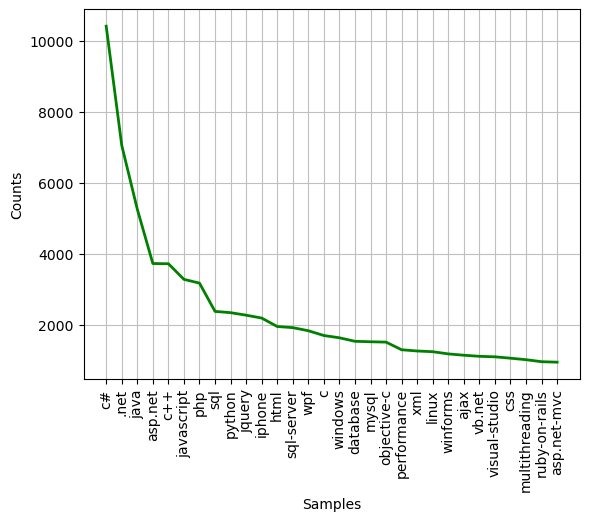

In [210]:
# c'est la qu'il faut faire l'analyse des tags pour diminuer 
fq = FreqDist(corpus_tag.split(' '))
print('Les 30 tags les plus present dans nos données :\n',fq.most_common(30))
fq.plot(30, cumulative=False, c='g')

In [212]:
# Pour afficher les moins present trions notre fq
print("Les 30 tags les moins présents dans nos données :\n", sorted(fq.items(), key=lambda x: x[1])[:30])

Les 30 tags les moins présents dans nos données :
 [('relative-time-span', 1), ('timezone-offset', 1), ('phpstorm', 1), ('apple-touch-icon', 1), ('long-long', 1), ('cmmi', 1), ('ms-solution-framework', 1), ('webapplicationstresstool', 1), ('pylot', 1), ('javascript-debugger', 1), ('server-response', 1), ('responsive-design', 1), ('class-members', 1), ('n2', 1), ('session-replication', 1), ('common-tasks', 1), ('xmlnodelist', 1), ('resolutions', 1), ('openrdf', 1), ('fileparse', 1), ('authority', 1), ('wisa', 1), ('iis-8', 1), ('model-checking', 1), ('servlet-mapping', 1), ('iextenderprovider', 1), ('texnic-center', 1), ('clonenode', 1), ('sound-synthesis', 1), ('xpo', 1)]


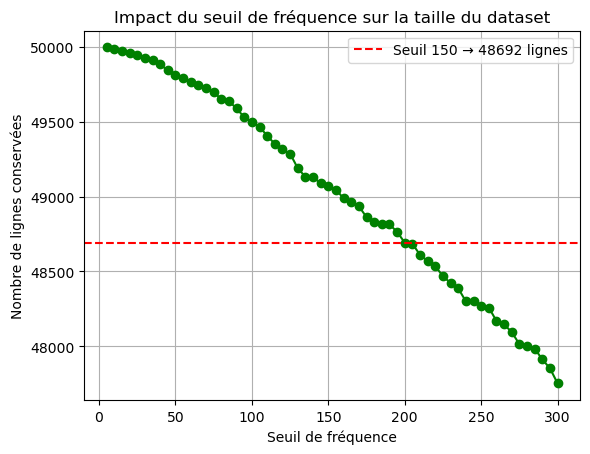

In [214]:
# Filtrons uniquement les tags rares dans chaque ligne, et supprimer la ligne seulement si tous ses tags sont rares.
thresholds = list(range(5, 301, 5))
sizes = []

for thresh in thresholds:
    tags_freq = {tag for tag, count in fq.items() if count >= thresh}
    df_temp = df.copy()
    df_temp['Tags'] = df_temp['Tags'].apply(lambda tags: [t for t in tags if t in tags_freq])
    df_temp = df_temp[df_temp['Tags'].map(len) > 0]
    sizes.append(len(df_temp))

# recuperons les coordonnées y au seuil cible
y = sizes[thresholds.index(200)]


plt.plot(thresholds, sizes, marker='o', c='g')

# Ligne rouge horizontale au niveau de y_target
plt.axhline(y=y, color='red', linestyle='--', label=f'Seuil 200 → {y} lignes')
plt.title("Impact du seuil de fréquence sur la taille du dataset")
plt.xlabel("Seuil de fréquence")
plt.ylabel("Nombre de lignes conservées")
plt.legend()
plt.grid(True)
plt.show()

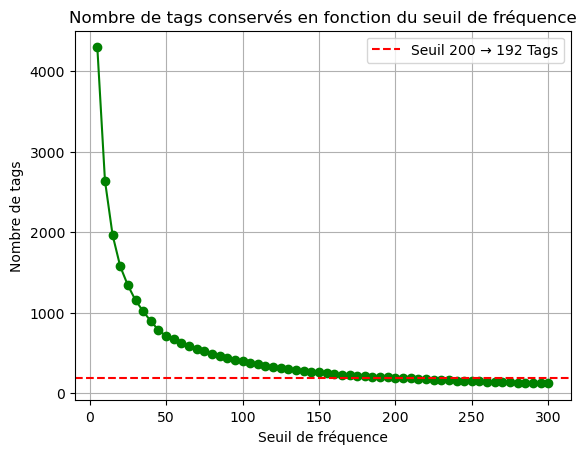

In [216]:
nb_tags = []

for thresh in thresholds:
    tags_freq = {tag for tag, count in fq.items() if count >= thresh}
    nb_tags.append(len(tags_freq))

# recuperons les coordonnées y au seuil cible
y = nb_tags[thresholds.index(200)]

plt.plot(thresholds, nb_tags, marker='o', c='g')

# Ligne rouge horizontale au niveau de y_target
plt.axhline(y=y, color='red', linestyle='--', label=f'Seuil 200 → {y} Tags')
plt.title("Nombre de tags conservés en fonction du seuil de fréquence")
plt.xlabel("Seuil de fréquence")
plt.ylabel("Nombre de tags")
plt.legend()
plt.grid(True)
plt.show()

- Seuil autour de 200 est un bon compromis :
je garde encore près de 97 % (48692 ligne) de tes lignes (cf. 1er graphique).
Tu réduis ton nombre de classes à 192 → beaucoup plus gérable pour ma machine.

In [219]:
MIN_FREQ = 200

# 1. Tags fréquents
tags_freq = {tag for tag, count in fq.items() if count >= MIN_FREQ}

# 2. Déduire les tags supprimés
DROP_TAGS = set(corpus_tag.split(' ')) - tags_freq   # Les tags qu'on a supprimés

# 3. Supprimer les tags rares de chaque liste
df['Tags'] = df['Tags'].apply(lambda tags: [t for t in tags if t in tags_freq])


# 4. Supprimer les lignes sans tags après le filtrage
df = df[df['Tags'].map(len) > 0]
df.shape

(48692, 3)

Les 30 tags les plus present dans nos données :
 [('c#', 10410), ('.net', 7051), ('java', 5252), ('asp.net', 3721), ('c++', 3715), ('javascript', 3275), ('php', 3168), ('sql', 2372), ('python', 2336), ('jquery', 2265), ('iphone', 2184), ('html', 1946), ('sql-server', 1914), ('wpf', 1827), ('c', 1692), ('windows', 1628), ('database', 1529), ('mysql', 1516), ('objective-c', 1506), ('performance', 1291), ('xml', 1256), ('linux', 1236), ('winforms', 1174), ('ajax', 1137), ('vb.net', 1106), ('visual-studio', 1092), ('css', 1053), ('multithreading', 1011), ('ruby-on-rails', 954), ('asp.net-mvc', 941)]


<Axes: xlabel='Samples', ylabel='Counts'>

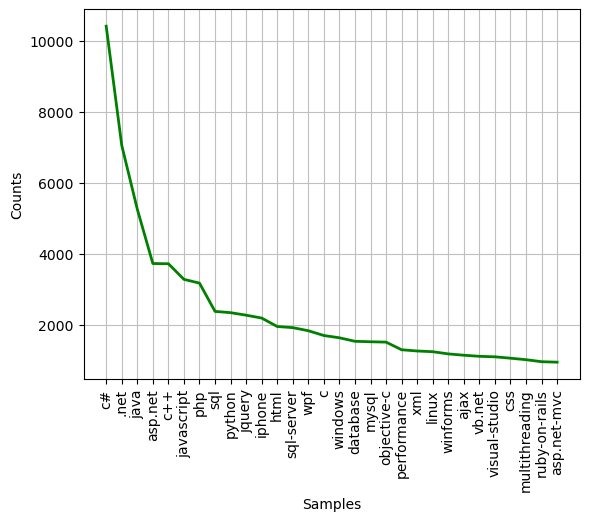

In [221]:
corpus_tag = restitution_corpus(df, 'Tags')
fq = FreqDist(corpus_tag.split(' '))
print('Les 30 tags les plus present dans nos données :\n',fq.most_common(30))
fq.plot(30, cumulative=False, c='g')

In [223]:
print("Les 30 tags les moins présents dans nos données :\n", sorted(fq.items(), key=lambda x: x[1])[:30])

Les 30 tags les moins présents dans nos données :
 [('iis-7', 200), ('utf-8', 204), ('audio', 205), ('assembly', 205), ('video', 206), ('mvvm', 207), ('rest', 208), ('memory-leaks', 210), ('windows-vista', 211), ('concurrency', 212), ('jdbc', 212), ('ms-access', 214), ('vba', 214), ('visual-studio-2005', 215), ('listview', 215), ('maven-2', 218), ('date', 220), ('ssl', 221), ('model-view-controller', 222), ('properties', 222), ('command-line', 223), ('interface', 224), ('variables', 224), ('types', 225), ('64-bit', 226), ('parameters', 228), ('boost', 228), ('configuration', 230), ('plugins', 230), ('user-controls', 230)]


In [225]:
# Pour gagner en temps de calcul (divisons nous même en token)
token_tag = (corpus_tag.lower()).split(' ')
token_tag = unique_preserve_order(token_tag)

LIST_EXCEPTION= []
doc_tag = nlp(' '.join(token_tag))
for tkn in doc_tag:
        # Filtrons sur la longueur des tokens
        if len(tkn.text)<=5 :
            # Si le token est '#' et que la liste des tokens n'est pas vide, fusionnons avec le précédent
            if tkn.text == "#" and LIST_EXCEPTION :
                LIST_EXCEPTION[-1] = LIST_EXCEPTION[-1] + "#"
            # Si le token contient un underscore, le conserver tel quel
            elif "_" in tkn.text :
                LIST_EXCEPTION.append(tkn.text)
            else :
                LIST_EXCEPTION.append(tkn.text)
                
LIST_EXCEPTION = set(LIST_EXCEPTION)
len(LIST_EXCEPTION)

69

In [227]:
# Verifion nos fonctions de nettoyage sur quelques textes avant de l'utiliser dans nos jeu de données 
examples = [
    "Calculate relative time in C#, Objective-C or NoSQL or just SQL? ",
    "Develop applications using C#, c++, .NET, ASP.NET, Node.js and Vue.js use.",
    "Python 3.8 is great, but C# has its own charm.",
    "Very interesting words to test state-of-the-art or (machine_learning or data_processing) like machine_learning more",
    "some tags that are not important relative-time-span timezone-offset long-long cmmi ms-solution-framework webapplicationstresstool pylot javascript-debugger"
]

for ex in examples:
    print(tokenize_and_lemmatize(ex))

calculate relative c# objective-c sql
develop application c# c++ .net asp.net vue.js
python c#
interesting state-of-the-art machine_learning data_processing
important


In [229]:
# Après validation utilisons nos fonctions de nettoyage sur notre jeu de donnée
df['text'] = df['Title'] + ' ' + df['Body']
df = cleaning_text(df,['text'])
#df = pd.read_csv('données_propre/donnees_propre.csv')
df.head(3)

,Title,Body,Tags,text,text_clean
0,How to convert Decimal to Double in C#?,I want to assign the decimal variable trans to...,[c#],How to convert Decimal to Double in C#? I want...,convert c# variable this.opacity trackbar1.val...
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp...","[c#, datetime]",Calculate relative time in C# Given a specific...,calculate relative c# specific datetime
2,Determine a user's timezone,Is there a standard way for a web server to be...,"[html, browser]",Determine a user's timezone Is there a standar...,determine standard http string


In [231]:
# restitution de corpus (title, body) et faire une EDA dessus
corpus_propre = restitution_corpus(df,'text_clean', c_list = False)
corpus = restitution_corpus(df,'text', c_list = False)

Les corpus prorpes : 1321133 
Les corpus originels : 7687981
Les 30 mots les plus frequents dans nos données :
 [('problem', 10229), ('create', 9678), ('thank', 8984), ('application', 8911), ('file', 8239), ('class', 7816), ('try', 7249), ('question', 6998), ('example', 6955), ('method', 6832), ('follow', 6687), ('object', 6457), ('function', 6121), ('change', 6099), ('string', 6039), ('possible', 5706), ('work', 5620), ('database', 4840), ('different', 4731), ('c#', 4606), ('result', 4444), ('look', 4443), ('update', 4437), ('simple', 4275), ('access', 4082), ('.net', 3987), ('list', 3836), ('control', 3831), ('text', 3727), ('write', 3694)]
Les 30 mots les moins présents dans nos données :
 [('trackbar1.value', 1), ('atan(1', 1), ('auto-fold', 1), ('atan2(0', 1), ('pitimes.c#', 1), ('10000000#', 1), ('testwith(x', 1), ('printf("%s\\t=#', 1), ('diffclock(time2', 1), ('diffclock(clock_t', 1), ('testwith(4', 1), ('atan2(1#', 1), ('defined(__gnuc', 1), ('defined(__i386', 1), ('defined(__

<Axes: xlabel='Samples', ylabel='Counts'>

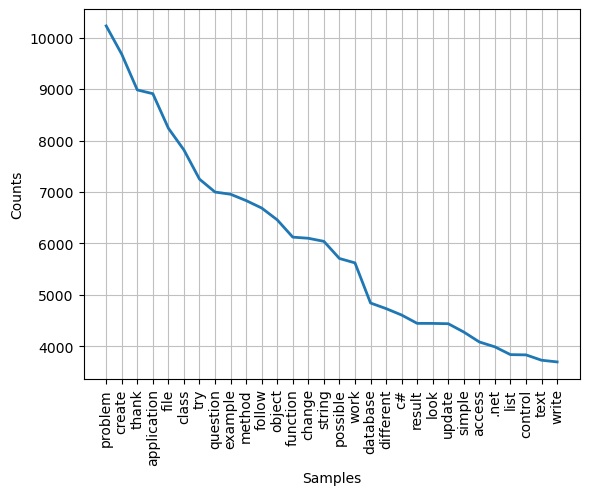

In [233]:
fq = FreqDist(corpus_propre.split())
print('Les corpus prorpes : ' + str(len(corpus_propre.split())), '\nLes corpus originels : ' +str(len(corpus.split())))
print('Les 30 mots les plus frequents dans nos données :\n',fq.most_common(30))
print("Les 30 mots les moins présents dans nos données :\n", sorted(fq.items(), key=lambda x: x[1])[:30])
fq.plot(30, cumulative=False)

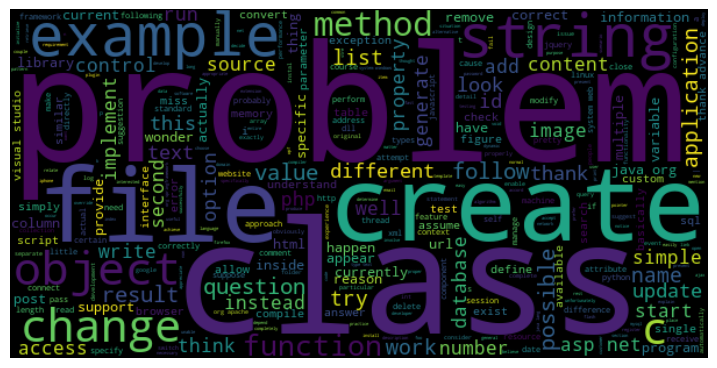

In [235]:
# creation d'un wordcloud.
wordcloud = WordCloud(
    random_state = 404,
    normalize_plurals = False,
    width = 600,
    height= 300,
    max_words = 300,
    stopwords = []
)
wordcloud.generate(corpus_propre)
plt.figure(figsize = (9,6))
# ajoutons interpolation = bilinear pour arrondir les angles
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [245]:
df.to_csv('données_propre/donnees_propre.csv', index=False)